### 검증 세트

모델 성능을 향상하기 위해 다양한 하이퍼파라미터를 시도하는 과정에서 테스트 세트를 사용하면 테스트 세트에 맞춰 모델을 훈련하게 됨

-> 따라서 테스트 세트는 최종 모델을 선택할 때까지 사용하지 말아야 함

-> 테스트 세트를 사용하지 않고 모델을 평가하려면 또 다른 세트가 필요한데 이를 검증 세트(개발 세트)라고 함


검증 세트 : 하이퍼파라미터 튜닝을 위해 모델을 평가할 때, 테스트 세트를 사용하지 않기 위해 훈련 세트에서 다시 떼어 낸 데이터 세트

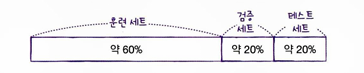

In [1]:
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')

data = wine[['alcohol', 'sugar', 'pH']]
target = wine['class']

In [2]:
# 테스트 세트 분리
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [3]:
# 검증 세트 분리
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [4]:
# 훈련 세트와 검증 세트 크기 확인
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [5]:
# 모델 훈련 및 평가
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

# -> 과대적합

0.9971133028626413
0.864423076923077


### 교차 검증
*   훈련한 모델의 성능을 안정적으로 평가하기 위해 수행
*   훈련 세트를 여러 폴드로 나눈 다음 한 폴드가 검증 세트의 역할을 하고 나머지 폴드에서는 모델을 훈련 -> 모든 폴드에 대해 검증 점수를 얻어 평균
*   검증 세트를 떼어 내어 평가하는 과정을 여러 번 반복 후 점수를 평균하여 최종 검증 점수를 얻음


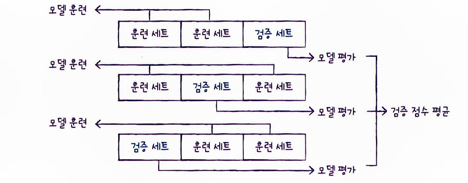

#### cross_validate() : 교차 검증을 수행하는 함수
* 첫 번째 매개변수에 교차 검증을 수행할 모델 객체 전달
* 두 번째와 세 번째 매개변수에 특성과 타깃 데이터를 전달
* scoring : 검증에 사용할 평가 지표 지정 (기본적으로 분류 모델은 정확도를 의미하는 'accuracy', 회귀 모델은 결정계수를 의미하는 'r2')
* cv : 교차 검증 폴드 수나 분할기 객체 지정 (기본값은 5, 회귀일 때는 KFold 클래스를 사용하고 분류일 때는 StratifiedKFold 클래스를 사용하여 5-폴드 교차 검증 수행)
* n_jobs : 교차 검증을 수행할 때 사용할 CPU 코어 수 (기본값은 1 : 하나의 코어 사용, -1로 지정하면 시스템에 있는 모든 코어 사용)
* return_train_score : True로 지정하면 훈련 세트의 점수도 반환 (기본값은 False)

In [6]:
# 교차 검증
# cross_validate() : 기본적으로 5-폴드 교차 검증 수행
# cross_validate()는 훈련 세트를 섞지 않음 (train_test_split() 함수는 데이터 섞는 과정을 포함하기 때문에 따로 섞을 필요 x) -> 훈련 세트를 섞으려면 분할기를 지정해야 함
# fit_time : 모델 훈련 시간 / score_time : 검증 시간
from sklearn.model_selection import cross_validate
scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.0110898 , 0.01784611, 0.00973272, 0.00981283, 0.02266526]), 'score_time': array([0.00552249, 0.00248766, 0.00221348, 0.00209856, 0.00278449]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [7]:
# 검증 폴드의 점수
import numpy as np
print(np.mean(scores['test_score']))

0.855300214703487


In [8]:
# 사이킷런의 분할기는 교차 검증에서 폴드를 어떻게 나눌지 결정
# cross_validate() 함수는 기본적으로 회귀 모델일 경우 KFold 분할기를 사용하고 분류 모델일 경우 타깃 클래스를 골고루 나누기 위해 StratifiedKFold를 사용
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


In [9]:
# 훈련 세트를 섞은 후 10-폴드 교차 검증을 수행하려면 다음과 같이 작성
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


### 그리드 서치

* 하이퍼파라미터 탐색을 자동화해 주는 도구
* 교차 검증으로 최적의 하이퍼파라미터 탐색 후 훈련 세트 전체를 사용해 최종 모델 훈련

1. 탐색할 매개변수 지정
2. 훈련 세트에서 그리드 서치를 수행하여 최상의 평균 검증 점수가 나오는 매개변수 조합을 찾음. 이 조합은 그리드 서치 객체에 저장 됨
3. 최상의 매개변수 조합으로 (교차 검증에 사용한 훈련 세트가 아니라) 전체 훈련 세트를 사용해 최종 모델 훈련. 이 모델도 그리드 서치 객체에 저장 됨

#### GridSearchCV
* 첫 번째 매개변수로 그리드 서치를 수행할 모델 객체 전달
* 두 번째 매개변수에는 탐색할 모델의 매개변수와 값 전달
* scoring, cv, n_jobs, return_train_score 매개변수는 cross_validate() 함수와 동일

#### 하이퍼파라미터 튜닝


*   하이퍼파라미터 : 모델이 학습할 수 없어서 사용자가 지정해야만 하는 파라미터
*   AutoML :사람의 개입 없이 하이퍼파라미터 튜닝을 자동으로 수행하는 기술





In [10]:
# GridSearchCV 클래스 : 하이퍼파라미터 탐색과 교차 검증을 한 번에 수행
from sklearn.model_selection import GridSearchCV
# min_impurity_decrease : 노드를 분할하기 위한 불순도 감소 최소량 지정
params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [11]:
# 그리드 서치 객체 생성 및 훈련
# GridSearchCV의 cv 매개변수 기본값은 5 :  min_impurity_decrease 값마다 5-폴드 교차 검증 수행
# njobs : 병렬 실행에 사용할 CPU 코어 수 지정(기본값 1). -1로 지정하면 시스템에 있는 모든 코어 사용
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [12]:
# 그리드 서치는 훈련이 끝나면 교차 검증 점수가 가장 높은 모델의 매개변수 조합으로 전체 훈련 세트에서 자동으로 다시 모델을 훈련
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [13]:
# 그리드 서치로 찾은 최적의 매개변수
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [14]:
# 각 매개변수에서 수행한 교차 검증의 평균 점수
print(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][gs.best_index_]) # 가장 높은 값의 인덱스를 사용해 params 키에 저장된 매개 변수 출력

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]
{'min_impurity_decrease': 0.0001}


In [15]:
# max_depth : 트리의 깊이
# min_samples_split : 노드를 나누기 위한 최소 샘플 수
# np.arange() : 첫 번째 매개변수 값에서 시작하여 두 번째 매개변수에 도달할 때까지 세 번째 매개변수를 계속 더한 배열 생성
# range() : np.arange()와 비슷하지만 정수만 사용 가능
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }

In [16]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [17]:
# 최상의 매개변수 조합
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': np.float64(0.0004), 'min_samples_split': 12}


In [18]:
# 최상의 교차 검증 점수
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


### 랜덤 서치

* 연속된 매개변수 값을 탐색할 때 유용
* 탐색할 값을 직접 나열하는 것이 아니고 탐색 값을 샘플링할 수 있는 확률 분포 객체를 전달
* 교차 검증으로 랜덤한 하이퍼파라미터 탐색하여 최상의 모델을 찾은 후 훈련 세트 전체를 사용해 최종 모델을 훈련
* 지정된 횟수만큼 샘플링하여 교차 검증을 수행하기 때문에 시스템 자원이 허락하는 만큼 탐색량 조절 가능

####  RandomizedSearchCV
* 첫 번째 매개변수로 그리드 서치를 수행할 모델 객체 전달
* 두 번째 매개변수에는 탐색할 모델의 매개변수와 확률 분포 객체를 전달
* scoring, cv, njobs, return_train_score 매개변수는 cross_validate() 함수와 동일

In [19]:
# 균등 분포에서 샘플링
# randint는 정숫값을 뽑고, uniform은 실숫값을 뽑음
from scipy.stats import uniform, randint

In [20]:
# 탐색할 매개변수 범위
# min_samples_leaf : 리프 노드가 되기 위한 최소 샘플의 개수
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

In [21]:
# n_iter : 샘플링 횟수
from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
rs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ee6aed75af0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ee6af44e4b0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ee6aed76930>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ee6aed743e0>},
                   random_state=42)

In [22]:
# 최적의 매개변수 조합
print(rs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': np.float64(0.00034102546602601173), 'min_samples_leaf': 7, 'min_samples_split': 13}


In [23]:
# 최고의 교차 검증 점수
print(np.max(rs.cv_results_['mean_test_score']))

0.8695428296438884


In [24]:
# 최적의 모델은 전체 훈련 세트로 훈련되어 best_estimator_ 속성에 저장 됨
dt = rs.best_estimator_
print(dt.score(test_input, test_target))

0.86


#### 확인문제

In [25]:
gs = RandomizedSearchCV(DecisionTreeClassifier(splitter='random', random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42,
                                                    splitter='random'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ee6aed75af0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ee6af44e4b0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ee6aed76930>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ee6aed743e0>},
                   random_state=42)

In [26]:
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))

dt = gs.best_estimator_
print(dt.score(test_input, test_target))

{'max_depth': 43, 'min_impurity_decrease': np.float64(0.00011407982271508446), 'min_samples_leaf': 19, 'min_samples_split': 18}
0.8458726956392981
0.786923076923077
